util

In [ ]:
class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

In [ ]:
def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img
def get_bernoulli_mask(for_image, zero_fraction=0.9):
    img_mask_np=(np.random.random_sample(size=pil_to_np(for_image).shape) > zero_fraction).astype(int)
    img_mask = np_to_pil(img_mask_np)
    
    return img_mask

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 

    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np


def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)


In [ ]:
def load_LR_HR_imgs_sr(LR_image,HR_image, imsize, factor, enforse_div32=None):
    
    img_orig_pil, img_orig_np = get_image(HR_image, -1)

    if imsize != -1:
       img_orig_pil, img_orig_np = get_image(HR_image, imsize)
        
  
    img_HR_pil, img_HR_np = img_orig_pil, img_orig_np
        
    LR_size = [
               img_HR_pil.size[0] // factor, 
               img_HR_pil.size[1] // factor
    ]
    
    img_LR_pil, img_LR_np = get_image(LR_image, -1)
    # img_LR_pil = img_HR_pil.resize(LR_size, Image.ANTIALIAS)
    img_LR_np = pil_to_np(img_LR_pil)

    print('HR and LR resolutions: %s, %s' % (str(img_HR_pil.size), str (img_LR_pil.size)))

    return {
                'orig_pil': img_orig_pil,
                'orig_np':  img_orig_np,
                'LR_pil':  img_LR_pil, 
                'LR_np': img_LR_np,
                'HR_pil':  img_HR_pil, 
                'HR_np': img_HR_np
           }

def get_noisy_image(img_np, sigma):
    """Adds Gaussian noise to an image.
    
    Args: 
        img_np: image, np.array with values from 0 to 1
        sigma: std of the noise
    """
    img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma, size=img_np.shape), 0, 1).astype(np.float32)
    #img_noisy_np = (img_np + np.random.normal(scale=sigma, size=img_np.shape)).astype(np.float32)
    img_noisy_pil = np_to_pil(img_noisy_np)

    return img_noisy_pil, img_noisy_np

Parameters

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np

import torch
import torch.optim
from torch import nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import skimage
import time


# noise
sigma = 25
sigma_ = sigma/255.
imsize = -1 
# SR
factor = 4 # 8
# Inpainting
Sparsity=0.1
zero_f=1-Sparsity

Set path 

In [ ]:
#for task include SR   
SR=True
img_path= '/content/drive/MyDrive/Set5/image_SRF_4/img_002_SRF_4_HR.png'

LR_image = '/content/drive/MyDrive/Set5/image_SRF_4/img_002_SRF_4_LR_LANCZOS.png'#bicubic
HR_image = img_path

#for denoise + mask task the three path is the same
# SR=False
# img_path= '/content/drive/MyDrive/Self2Self_pytorch_implementation-test/Self2Self_pytorch_implementation-main/testsets/set9/image_Peppers512rgb.png'

# LR_image = img_path
# HR_image = img_path

Get images

HR and LR resolutions: (288, 288), (72, 72)


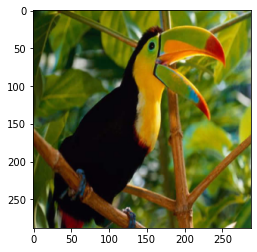

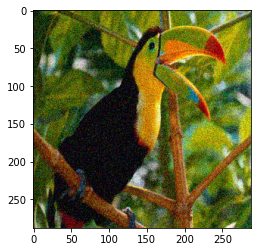

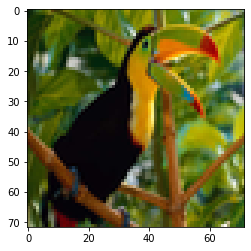

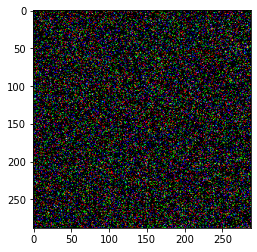

In [ ]:
    
img_pil, img_np = get_image(HR_image, imsize)    
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
imgs = load_LR_HR_imgs_sr(LR_image, HR_image , imsize, factor)
img_mask = get_bernoulli_mask(img_pil, zero_f)
img_mask_np = pil_to_np(img_mask)
img_mask_np[1] = img_mask_np[0]
img_mask_np[2] = img_mask_np[0]
plt.imshow(img_pil)
plt.pause(0.1) 
plt.imshow(img_noisy_pil) 
plt.pause(0.1) 
plt.imshow(imgs['LR_pil']) 
plt.pause(0.1) 
plt.imshow(img_mask)
plt.pause(0.1) 


SIREN model

In [ ]:



def get_origin_mgrid(sidelen1,sidelen2, dim=2):

    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid


class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        



Initialize

In [ ]:
class ImageFitting(Dataset):
    def __init__(self,sidelength1,sidenlength2):
        super().__init__()
        
        
        self.coords = get_origin_mgrid(sidelength1,sidelength2,dim=2)
        
    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
          
        return self.coords

In [ ]:
sidelength1=img_noisy_np.shape[1]
sidelength2=img_noisy_np.shape[2]
print(sidelength1,sidelength2)
image = ImageFitting(sidelength1,sidelength2)
dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True)
img_siren.cuda()

288 288


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

Train

Step 0, Total loss 0.479017


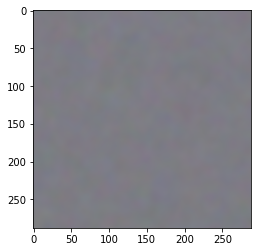

<ipython-input-81-f1c4bc12c5c0>:71: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM = ssim(gt,output , multichannel=True)


ssim =  0.3322622
psnr =  9.571622481090598
time =  0.3305792808532715


Step 500, Total loss 0.003290


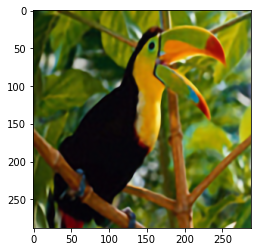

ssim =  0.9617391
psnr =  33.289133220104404
time =  10.019554138183594


In [ ]:
total_steps = 501
steps_til_summary = 500
start_time=time.time()
figsize = 4 
KERNEL_TYPE='lanczos2'
dtype = torch.cuda.FloatTensor
downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

#get all images
img_noisy_input=(img_noisy_np-0.5)*2
noisy_image = torch.tensor(img_noisy_input).permute(1,2,0).view(-1,3).cuda()       
mask=torch.tensor(img_mask_np).permute(1,2,0).view(-1,3).cuda()
img_gt=torch.tensor(img_np).permute(1,2,0).view(-1,3).cuda()
img_gt=(img_gt-0.5)*2
img_LR_gt=torch.tensor(imgs['LR_np']).permute(1,2,0).view(-1,3).cuda()
img_LR_gt=(img_LR_gt-0.5)*2  
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
model_input= next(iter(dataloader))
model_input= model_input.cuda()
gt=img_np.transpose(1,2,0)
for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
   

    ## SR+denoise

    model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    loss1 = ((model_outputnew - img_LR_gt)**2).mean()
    loss2=((model_output - noisy_image)**2).mean()
    loss=loss1+0.1*loss2

    #mask+denoise

    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2=((model_output - noisy_image)**2).mean()
    # loss=loss1+0.1*loss2
    

    ##mask+SR
    # model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2 = ((model_outputnew - img_LR_gt)**2).mean()
    # loss=loss1+loss2

    #three
    # model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2 = ((model_outputnew - img_LR_gt)**2).mean()
    # loss3 =((model_output - noisy_image)**2).mean()
    # loss=loss1+loss2+0.1*loss3
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
              
        output=model_output.cpu().view(sidelength1,sidelength2,3).detach().numpy()
        outputforplot=model_output.cpu().view(1,sidelength1,sidelength2,3).detach().numpy()
        output=(output+1)/2
        outputforplot=(outputforplot+1)/2
        #both plt method can be used

        plt.imshow(output)
        plt.pause(0.1)

        

        #save image
        # imgnewout=np_to_pil(outtt.transpose(2,0,1))
        # imgnewout.save('multi result/out1srmaskbiinr.png')

        #print metrics
        SSIM = ssim(gt,output , multichannel=True)
        print("ssim = ", SSIM)
        PSNR = psnr(gt,output )
        print("psnr = ", PSNR)
        end_time=time.time()
        print("time = ",end_time-start_time)
        
        
    
    optim.zero_grad()
    loss.backward()
    optim.step()

